# Imports

In [44]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Creating a Dataset

In [45]:
class FlickrDataset(object):
    def __init__(self):
        self.image_list = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/flickr30k_images/results.csv', sep='|')['image_name'].drop_duplicates().reset_index(drop=True)
        self.root_path = '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
        
    def __len__(self):
        return self.image_list.shape[0]
    
    def __getitem__(self, index):
        sample = {
            'Image': Image.open(self.root_path + self.image_list.iloc[index])
        }
        sample['BWImage'] = sample['Image']
        trans = transforms.Compose([
            transforms.Resize((150, 150)),
        ])
        to_bw = transforms.Grayscale(num_output_channels=3)
        to_tens = transforms.ToTensor()
        sample['Image'] = to_tens(trans(sample['Image']))
        sample['BWImage'] = to_tens(to_bw(trans(sample['BWImage'])))
        return sample

In [46]:
flick_dataset = FlickrDataset()

train_set, validation_set = torch.utils.data.random_split(flick_dataset, [len(flick_dataset) - 200, 200])

In [47]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

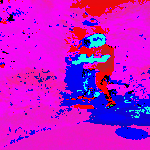

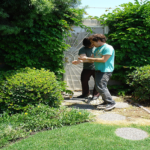

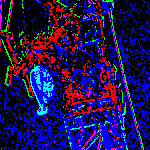

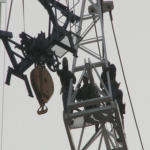

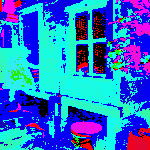

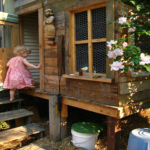

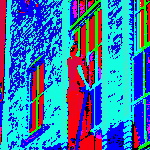

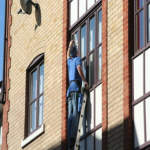

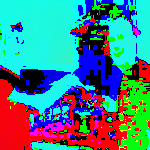

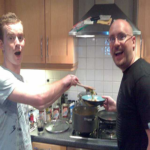

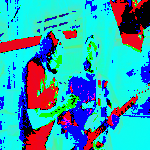

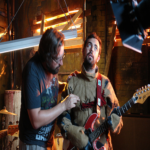

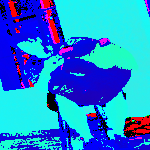

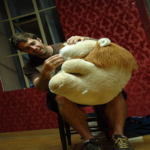

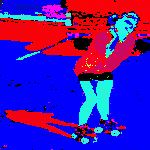

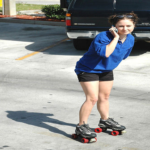

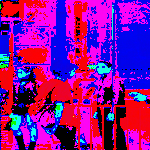

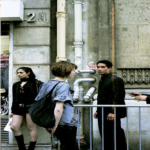

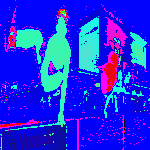

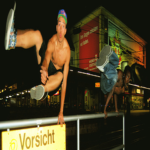

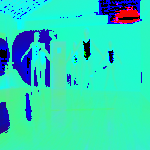

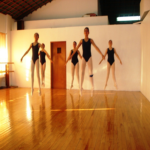

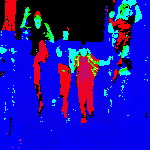

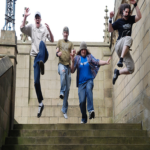

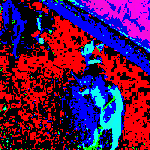

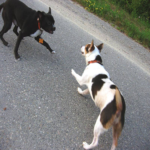

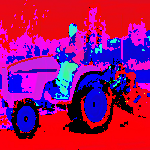

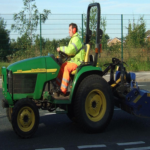

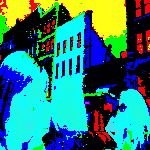

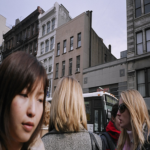

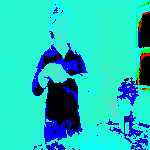

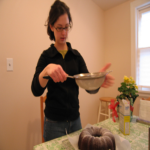

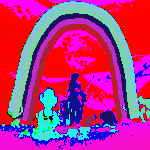

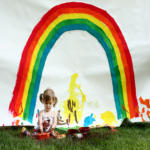

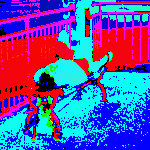

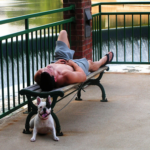

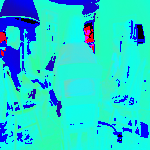

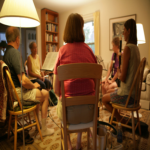

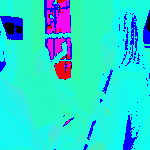

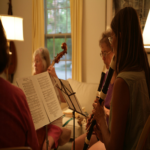

In [48]:
for i in range(20):
    display(transforms.ToPILImage()(flick_dataset[i]['Image'] - flick_dataset[i]['BWImage']))
    display(transforms.ToPILImage()(flick_dataset[i]['Image']))

In [49]:
def train(network, optimizer, trainloader, nb_epoch, validationloader=None, cuda=True):
    criterion = torch.nn.MSELoss(reduction='sum')
    size = train_loader.dataset.__len__()
    log_epoch = ''
    batch_size = 32
    for epoch in range(nb_epoch):
        log_epoch += 'Epoch :' + str(epoch + 1) + '\n'
        network.train()
        log_batch = ''
        i = 0
        batch_loss = 0
        for batch in iter(trainloader):
            X = batch['BWImage']
            Y = batch['Image']
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
            optimizer.zero_grad()
            output = network.forward(X)
            loss = criterion(output.float().cuda()+255, Y.float().cuda()+255)
            batch_loss+=loss
            loss.backward()
            optimizer.step()
            if i*batch_size%96 == 0:
                pourc = 100*i*batch_size/size
                log_batch = '[' + "".join(['-']*int(pourc) + ['_']*int(100-pourc)) + '] ' + str(pourc) + '%, live_loss : ' + str(float(batch_loss)/96) + '\n'
                clear_output()
                for j in range(3):
                    display(transforms.ToPILImage()(batch['BWImage'][j].cpu()))
                    display(transforms.ToPILImage()(output[j].cpu()))
                    display(transforms.ToPILImage()(batch['Image'][j].cpu()))
                batch_loss = 0
                print(log_epoch + log_batch)
            # PLOTTING AT EACH BATCH
            i+=1
    if not(validationloader is None):
        epoch_loss = []
        with torch.no_grad():
            for batch in iter(validationloader):
                X = batch['BWImage']
                Y = batch['Image']
                if cuda:
                    X = X.cuda()
                    Y = Y.cuda()
                output = network.forward(X)
                loss = criterion(output.cuda(), Y.cuda())
                epoch_loss.append(loss)
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
    #log_epoch += ' validation_loss : ' + str(float(epoch_loss)) + ' dice_coef : ' + str(sum(dices)/len(dices)) + ', ' + str((epoch_loss1, epoch_dice1)) + '\n'
    #clear_output()
    #print(log_epoch)

In [50]:
class NetTest(nn.Module):
    def __init__(self):
        super(NetTest, self).__init__()
        self.fcn_resnet50 = models.segmentation.fcn_resnet101(pretrained=True, progress=True)
        print(self.fcn_resnet50.parameters())
        for param in self.fcn_resnet50.parameters():
            param.requires_grad = False
        for param in self.fcn_resnet50.classifier.parameters():
            param.requires_grad = True
        for param in self.fcn_resnet50.backbone.layer4.parameters():
            param.requires_grad = True
        #for param in self.fcn_resnet50.backbone.layer3.parameters():
        #    param.requires_grad = True
        self.conv_red = torch.nn.Conv2d(kernel_size=3, in_channels=24, out_channels=17, padding=1)
        self.conv_red2 = torch.nn.Conv2d(kernel_size=3, in_channels=17, out_channels=12, padding=1)
        self.conv_red3 = torch.nn.Conv2d(kernel_size=3, in_channels=12, out_channels= 7, padding=1)
        self.conv_red4 = torch.nn.Conv2d(kernel_size=3, in_channels=7, out_channels= 3, padding=1)
        
    def forward(self, image):
        return self.conv_red4(self.conv_red3(self.conv_red2(self.conv_red.forward(torch.cat((image, self.fcn_resnet50.forward(image)['out']), 1)))))

In [51]:
nettest = NetTest()

<generator object Module.parameters at 0x7fce57fe8468>


In [52]:
nettest.cuda()

NetTest(
  (fcn_resnet50): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (r

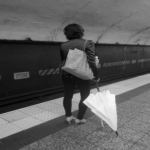

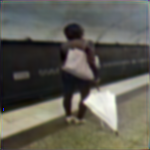

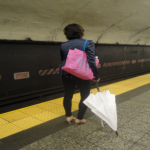

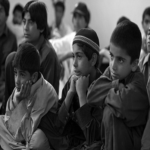

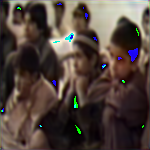

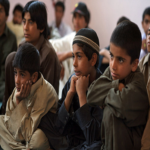

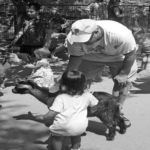

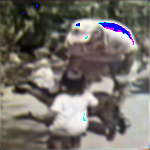

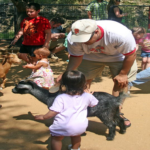

Epoch :1
[---------------------------------------------------------------------------------------------------] 99.6992052686572%, live_loss : 632.356201171875



In [60]:
train(nettest, optim.Adam(nettest.parameters(), lr=0.0001), train_loader, 1, cuda=True)

In [82]:
images = next(iter(validation_loader))
image = images['BWImage'].cuda()
Y = images['Image']
res = nettest(image)

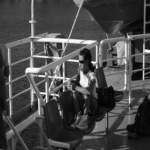

In [83]:
transforms.ToPILImage()(image[0].cpu())

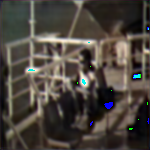

In [84]:
transforms.ToPILImage()(res[0].cpu())

IndexError: index 8 is out of bounds for dimension 0 with size 8

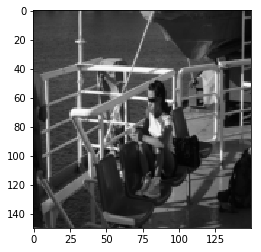

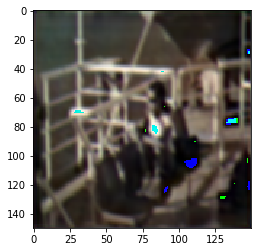

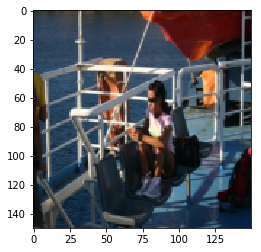

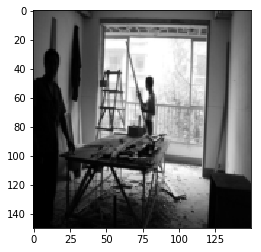

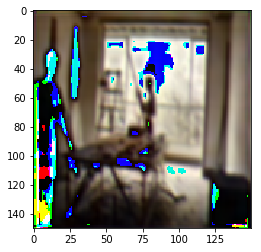

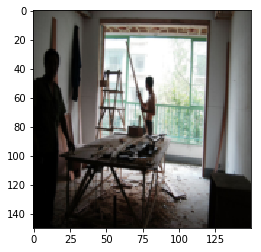

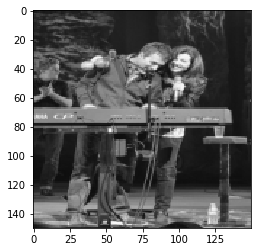

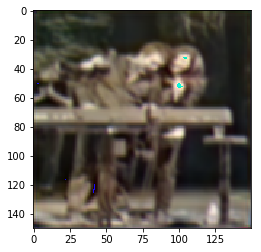

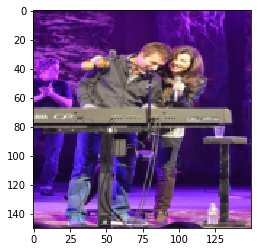

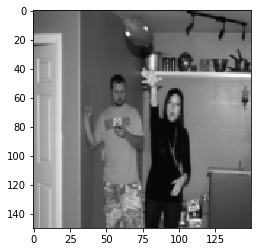

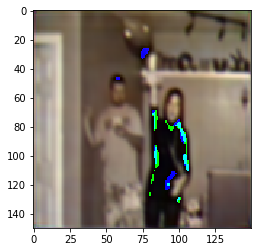

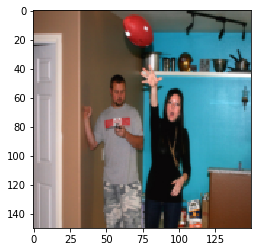

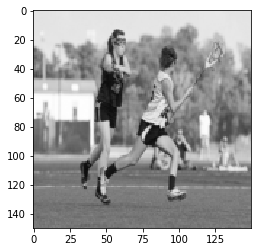

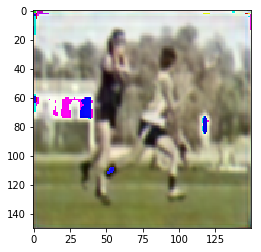

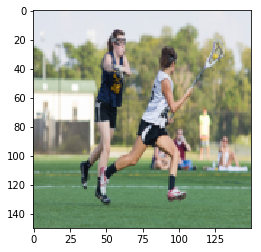

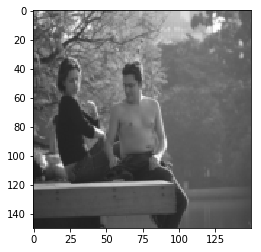

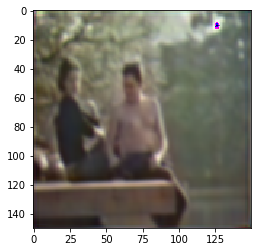

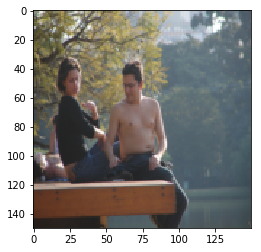

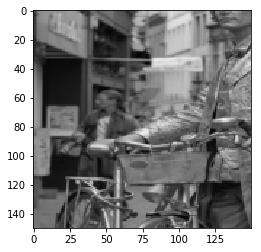

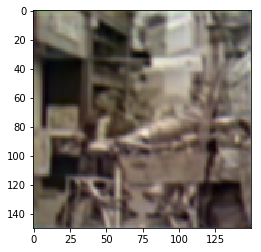

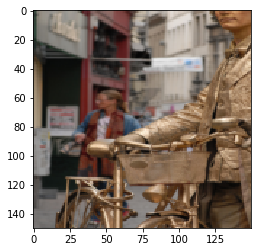

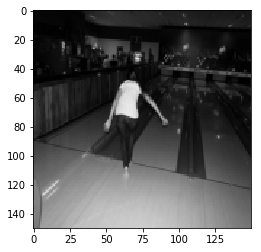

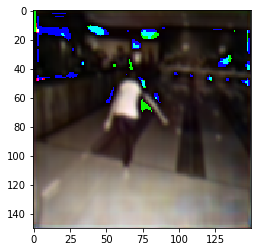

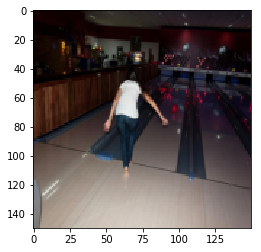

<Figure size 432x288 with 0 Axes>

In [85]:
for i in range(32):
    plt.figure()
    plt.imshow(transforms.ToPILImage()(image[i].cpu()))
    plt.figure()
    plt.imshow(transforms.ToPILImage()(res[i].cpu()))
    plt.figure()
    plt.imshow(transforms.ToPILImage()(Y[i].cpu()))

In [ ]:
test = models.segmentation.fcn_resnet101(pretrained=True, progress=True)

In [ ]:
test.backbone.layer4

In [ ]:
iter(validation_loader)[2]